# Проект: Мобильная игра (вариант 1)

В данном проекте, мы будем анализировать данные мобильного приложения. Коллега из бизнес-подразделения просит у нас решить с следуюзщие задачи:

1. В первую очередь, его интересует показатель retention. Напишем функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определим, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложим метрики для оценки результатов последнего прошедшего тематического события в игре.

ЗАДАЧА 1. Написать функцию для рассчета показателя retention.

In [1]:
#импортируем все необходимые библиотеки для анализа данных

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date,timedelta
from scipy import stats
from scipy.stats import norm, mannwhitneyu
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

%matplotlib inline

In [2]:
#настройка графиков
sns.set(
    font_scale = 1,
    style = "whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [3]:
#1. Считываем данные из файла "problem1-reg_data.csv" и сохраняем в датафрейм "reg_data".
reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-allaberganov/shared/problem1-reg_data.csv', sep = ';')
reg_data.head(5)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
#2. Считываем данные из файла "problem1-auth_data.csv" и сохраняем в датафрейм "auth_data".
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-allaberganov/shared/problem1-auth_data.csv', sep = ';')
auth_data.head(5)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Полученные датафреймы состоят из двух столбцов. Мы заметили, что первый столбец в датафреймах указывают на дату, но они представлены в unix-формате, который является не читабельным и не подходит для дальнейшего анализа. Поэтому, далее мы переводим даты в нужный формат, посмотрим на тип данных, посчитаем количество уникальных значений в таблице "uid" для каждого датафрейма для того, чтобы сравнить количество игроков.

In [5]:
#3. Переводим формат "unix" на формат "datetime"
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit = 's').dt.strftime('%Y-%m-%d')
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], format = '%Y-%m-%d')

In [6]:
#4. Смотрим на полученный результат
reg_data.head(5)

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5


In [7]:
#5. Изучаем количество значений в датафрейме, смотрим на тип данных
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   reg_ts  1000000 non-null  datetime64[ns]
 1   uid     1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.3 MB


In [8]:
#6. Переводим формат "unix" на формат "datetime"
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit = 's').dt.strftime('%Y-%m-%d')
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], format = '%Y-%m-%d')

In [9]:
#7. Смотрим на полученный результат
auth_data.head(5)

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


In [10]:
#8. Изучаем количество значений в датафрейме, смотрим на тип данных
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype         
---  ------   -----         
 0   auth_ts  datetime64[ns]
 1   uid      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 146.5 MB


In [11]:
#9. Смотрим на количество уникальных значений в каждом столбце
reg_data.nunique()

reg_ts       5110
uid       1000000
dtype: int64

In [12]:
#10. Минимальная дата регистрации
reg_data['reg_ts'].min()

Timestamp('1998-11-18 00:00:00')

In [13]:
#11. Максимальная дата регистрации
reg_data['reg_ts'].max()

Timestamp('2020-09-23 00:00:00')

In [14]:
#12. Смотрим на количество уникальных значений в каждом столбце
auth_data.nunique()

auth_ts       6169
uid        1000000
dtype: int64

После предварительного изучения данных мы получили следующие выводы:
1. Датафрейм "reg_data" включает в себя информацию о дате регистрации каждого пользователя в период с 1998 по 2020 год.
2. Датафрейм "auth_data" включает в себя информацию о датах авторизации каждого пользователя, то есть заходы зарегистрированных пользователей в мобильную игру.
3. Количество уникальных игроков раняется 1 000 000.
4. Данные о заходах в игру включает в себя 9 601 013 дат.

Далее приступаем к анализу retention-пользователей.


In [16]:
#13. Объединяем датафреймы
full_data = auth_data.merge(reg_data, how = 'left', on = 'uid')
full_data = full_data[['uid', 'reg_ts', 'auth_ts']]
full_data

,uid,reg_ts,auth_ts
0,1,1998-11-18,1998-11-18
1,2,1999-07-22,1999-07-22
2,2,1999-07-22,1999-07-25
3,2,1999-07-22,1999-07-31
4,2,1999-07-22,1999-08-05
...,...,...,...
9601008,1110618,2020-09-23,2020-09-23
9601009,1110619,2020-09-23,2020-09-23
9601010,1110620,2020-09-23,2020-09-23
9601011,1110621,2020-09-23,2020-09-23


In [17]:
#14. Находим разницу (в днях) от каждой даты захода в игру и даты регистрации
full_data['days_diff'] = full_data['auth_ts'] - full_data['reg_ts']
full_data['days_diff'] = full_data['days_diff'].dt.days

In [18]:
#15. Отдельно извлекаем год регистрации 
full_data['reg_year'] = full_data['reg_ts'].dt.year

In [19]:
#16. Переименуем столбцы
full_data = full_data.rename(columns = {'uid': 'user_id',
                            'reg_ts': 'reg_date',
                            'auth_ts': 'active_dates',
                            'days_diff': 'active_days'})
full_data

,user_id,reg_date,active_dates,active_days,reg_year
0,1,1998-11-18,1998-11-18,0,1998
1,2,1999-07-22,1999-07-22,0,1999
2,2,1999-07-22,1999-07-25,3,1999
3,2,1999-07-22,1999-07-31,9,1999
4,2,1999-07-22,1999-08-05,14,1999
...,...,...,...,...,...
9601008,1110618,2020-09-23,2020-09-23,0,2020
9601009,1110619,2020-09-23,2020-09-23,0,2020
9601010,1110620,2020-09-23,2020-09-23,0,2020
9601011,1110621,2020-09-23,2020-09-23,0,2020


In [20]:
#17. Изучаем типы данных и полученный результат после проведения манипуляций
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601013 entries, 0 to 9601012
Data columns (total 5 columns):
 #   Column        Dtype         
---  ------        -----         
 0   user_id       int64         
 1   reg_date      datetime64[ns]
 2   active_dates  datetime64[ns]
 3   active_days   int64         
 4   reg_year      int64         
dtypes: datetime64[ns](2), int64(3)
memory usage: 439.5 MB


In [21]:
#18. Изучаем максимальную длину (в днях) retention пользователей для каждого года.
full_data.groupby('reg_year', as_index = False)['active_days'].max()

,reg_year,active_days
0,1998,0
1,1999,7729
2,2000,0
3,2001,0
4,2002,51
5,2003,43
6,2004,48
7,2005,5590
8,2006,5353
9,2007,5010


Коллега из бизнеса просил у нас сделать функция для расчета retention (по дням, от даты регистрации), но после изучения данных, мы видим, что временной интервал состоит 21 года. И, для лучшего восприятия, предлагается смотреть на retention пользователей, регистрированных в конкретном году. Таким образом, мы делим на данные на сэмплы исходя из года регистарции пользователя.

Далее, мы будем тестировать нашу функцию на игроков регистрированных в 2019 году.

In [22]:
#19. Выбираем выборку для проверки работы функции
sample_data = full_data.query("reg_year == '2019'")
sample_data.head(5)

,user_id,reg_date,active_dates,active_days,reg_year
3383865,393071,2019-01-01,2019-01-01,0,2019
3383873,393073,2019-01-01,2019-01-01,0,2019
3383880,393074,2019-01-01,2019-01-01,0,2019
3383887,393075,2019-01-01,2019-01-01,0,2019
3383895,393076,2019-01-01,2019-01-01,0,2019


Название функции: retention_by_day. 
По умолчанию, данная функция принимает в себя 3 аргумента:

    reg_dates - данные о датах регистрации пользователей, 
    auth_dates - данные о каждом заходе игроков в мобильное приложение, 
    focus_year - год, в котором регистрировались игроки (наш сэмпл), то есть анализируем игроков зарегистрировавшихся именно в этом году.

In [23]:
#20. Функция, которая будет автомотизированно считать уровень удержания пользователей.

def retention_by_day(reg_dates, auth_dates, focus_year):
    
    reg_dates['reg_ts'] = pd.to_datetime(reg_dates['reg_ts'], unit = 's').dt.strftime('%Y-%m-%d')
    reg_dates['reg_ts'] = pd.to_datetime(reg_dates['reg_ts'], format = '%Y-%m-%d')
    
    auth_dates['auth_ts'] = pd.to_datetime(auth_dates['auth_ts'], unit = 's').dt.strftime('%Y-%m-%d')
    auth_dates['auth_ts'] = pd.to_datetime(auth_dates['auth_ts'], format = '%Y-%m-%d')
    
    full_data = auth_dates.merge(reg_dates, how = 'left', on = 'uid')
    
    full_data['days_diff'] = full_data['auth_ts'] - full_data['reg_ts']
    
    full_data = full_data.rename(columns = {'uid': 'user_id',
                            'reg_ts': 'reg_date',
                            'auth_ts': 'active_dates',
                            'days_diff': 'active_days'})
    
    year = str(focus_year)
    
    full_data['reg_year'] = full_data['reg_date'].dt.year
    sample_data = full_data.query("reg_year == @year")
    
    sample_data['active_days'] = sample_data['active_days'].dt.days
    
    retention_df = sample_data.groupby(['reg_date', 'active_days'])['user_id'].apply(pd.Series.nunique)
    cohort_df = pd.DataFrame(retention_df).reset_index()
    
    cohort_df_table = cohort_df.pivot(index = 'reg_date', columns = 'active_days', values = 'user_id')
    cohort_sizes = cohort_df_table.iloc[:,0]
    
    retention = round(cohort_df_table.divide(cohort_sizes, axis=0) * 100, 2)
    
    return retention

In [24]:
#21. Проверяем работоспособность функции на данных 2019 года.
retention_by_day = retention_by_day(reg_data, auth_data, 2019)
retention_by_day

active_days,0,1,2,3,4,5,6,7,8,9,...,622,623,624,625,626,627,628,629,630,631
reg_date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,100.0,2.06,3.77,4.97,4.46,6.35,8.23,5.83,5.49,6.00,...,0.86,1.20,1.20,0.86,1.03,1.03,1.72,1.03,1.20,0.34
2019-01-02,100.0,1.72,4.97,3.60,4.97,8.06,5.49,7.03,3.09,4.12,...,1.72,0.86,1.37,1.89,0.86,1.20,1.72,1.72,0.69,NaN
2019-01-03,100.0,1.71,3.08,4.44,5.98,6.32,6.50,5.81,2.22,4.96,...,1.03,1.20,1.71,1.20,1.37,1.37,1.20,0.51,NaN,NaN
2019-01-04,100.0,2.74,3.76,4.27,5.47,5.47,8.03,5.30,4.27,5.30,...,0.68,0.85,0.68,0.68,1.37,0.85,0.68,NaN,NaN,NaN
2019-01-05,100.0,1.88,4.10,4.61,4.95,8.19,7.17,7.00,5.97,4.10,...,1.37,1.71,2.05,0.85,1.88,0.68,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,100.0,2.37,3.70,3.13,5.32,5.98,6.36,7.03,4.08,5.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-28,100.0,1.80,3.89,4.46,5.12,6.74,6.45,5.69,5.60,4.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-29,100.0,1.42,4.82,5.30,5.77,5.39,7.00,5.87,5.87,4.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ниже, графически попытаемся показать полученные результаты на примере нашего сэмпла (sample_data). Данный график визуализирует какая доля пользователей, зарегистрированных за указанный год, удерживались в течении первых 30 дней. Такой подход лучше всего описывает полученные результаты. Классический пример для визуализации retention_rate, heatmap (тепловая карта) на таких длинных отрезках (retention по дням) не демонстрировал бы удобное восприятие информации. 

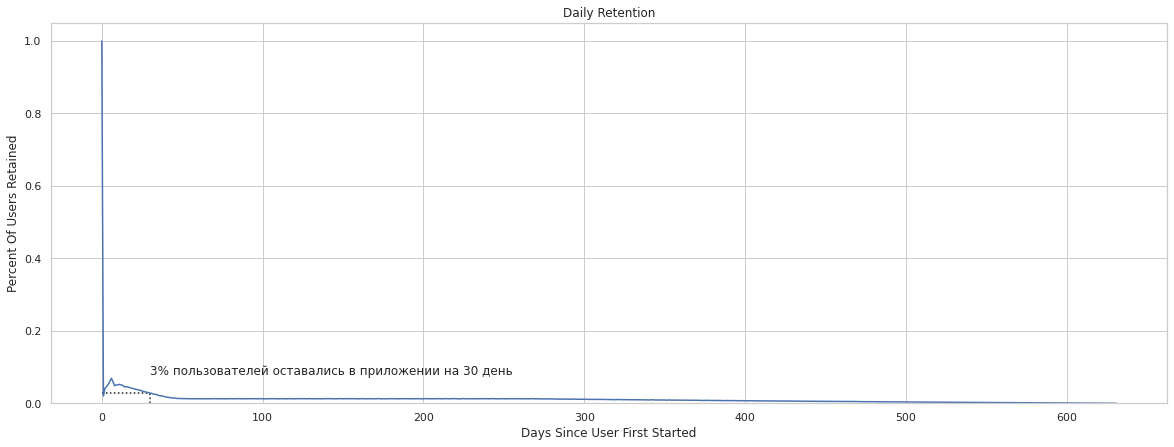

In [25]:
#22. Визуализируем полученные результаты
whole_retention = sample_data.groupby('active_days')['user_id'].nunique() / sample_data['user_id'].nunique()

plt.plot(whole_retention)
plt.title("Daily Retention")
plt.xlabel("Days Since User First Started")
plt.ylabel("Percent Of Users Retained")
plt.ylim(0,1.05)

plt.hlines(y=whole_retention.loc[30], xmin=0, xmax=30, linestyles='dotted')
plt.vlines(x=30, ymin=0, ymax=whole_retention.loc[30], linestyles='dotted')
plt.text(s=("{:.0%} пользователей оставались в приложении на 30 день".format(whole_retention.loc[30])),
        x=30, y=whole_retention.loc[30] + .05);

Подводя итоги первой задачи, мы можем сказать, что была создана функция, которая считает retention rate пользователей мобильным приложением начиная от даты регистрации. Для удобства, функция была реализована таким образом, чтобы можно было смотреть уровень удержание пользователей исходя из года их регистрации (сэмпл из годового среза). А также, для более качественного восприятия полученных результатов retention rate, реализовали график, который показывает долю пользователей, который пользовались приложением в течении 30 дней после даты регистрации. Такой подход лучше описывает картину чем heatmap, учитывая горизонт длительности дней.

ЗАДАЧА 2.

В компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определить, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.

In [26]:
#1. Считываем данные из файла "Проект_1_Задание_2.csv" и сохраняем в датафрейм "data".
data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-allaberganov/FINAL PROJECT/Проект_1_Задание_2.csv', sep = ';')
data

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [27]:
#2. Изучаем данные и смотрим на тип данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [28]:
#3. Посчитаем количество уникальных значений в каждой колонке
data.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

Из вышеуказанного шага видим, что все ячейки заполнены и не имеются пустых ячеек. Далее мы будем работать с группами, для которых предлагались разные виды акционных предложений. Для начало посчитаем количество платящих и неплатящих пользователей, посчитаем средний доход, который принес каждая группа, посмотрим на распределение данных в каждой выборке.

In [29]:
#4. Находим количество неплатящих пользователей
data.query("revenue == '0'") \
    .groupby('testgroup', as_index = False) \
    .agg({'user_id':'count'})

,testgroup,user_id
0,a,200175
1,b,200862


In [30]:
#5. Находим количество платящих пользователей
data.query("revenue !='0'") \
    .groupby('testgroup', as_index = False) \
    .agg({'user_id':'count'})

,testgroup,user_id
0,a,1928
1,b,1805


In [31]:
#6. Проверяем полученный результат
data_paying = data.query('revenue != 0')
data_paying

,user_id,revenue,testgroup
72,73,351,a
160,161,3797,b
341,342,290,a
377,378,3768,b
385,386,250,a
...,...,...,...
404315,404316,262,a
404525,404526,3120,b
404543,404544,369,a
404602,404603,251,a


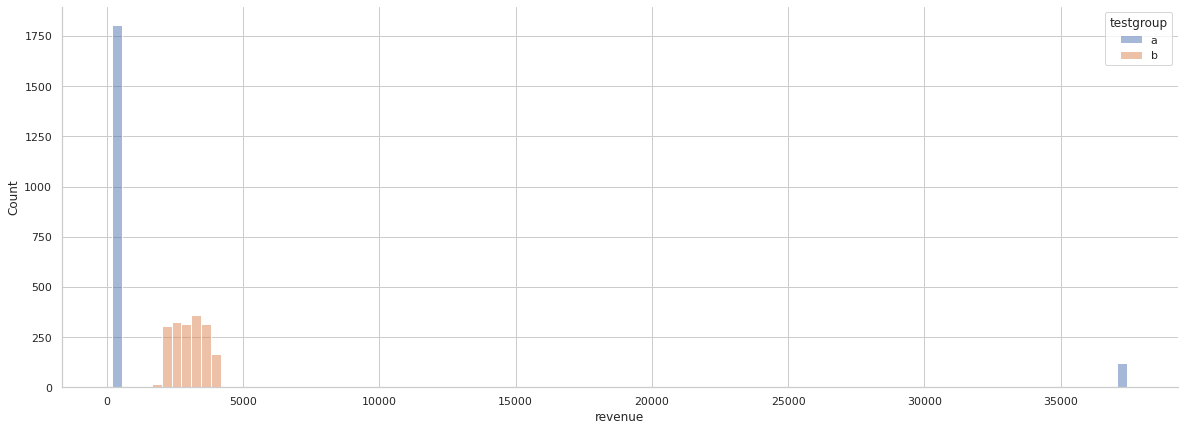

In [32]:
#7. Смотрим на распределение платящих пользователей  в каждой группе
sns.histplot(x = 'revenue', data = data_paying, hue = 'testgroup')
sns.despine()

Из полученнего графика мы можем заметить, что в оплатах платящих пользователей имеются выбросы, в группе "a" выбросы даже очень сильно выражены. Отсюда мы можем сделать вывод о ненормальном распеределении выборки. Далее мы проводим тест Шапиро-Уилка, чтобы это подтвердить. Если p-value меньше 0.05 мы можем сделать вывод, что распределение отклоняется от нормального.

In [33]:
#8. Проводим тест Шапиро. Распределение отклоняется от нормального.
group_a = data_paying[data_paying['testgroup'] == 'a']['revenue'].sample(1000, random_state=17)
stats.shapiro(group_a)

ShapiroResult(statistic=0.26476240158081055, pvalue=0.0)

In [34]:
#9. Проводим тест Шапиро. Распределение отклоняется от нормального.
group_b = data_paying[data_paying['testgroup'] == 'b']['revenue'].sample(1000, random_state=17)
stats.shapiro(group_b)

ShapiroResult(statistic=0.9613320827484131, pvalue=1.2885095898576755e-15)

Метрики, которые мы будем исследовать: Средний чек = ARPPU (так как данные состоят исключительно из уникальных пользователей, и одна покупка приходится на одного покупателя), ARPU (средний доход с пользователя) и CR (доля платящих пользователей среди всех пользователей).

In [35]:
#10. Подготовка к расчетам ARPPU (Средний чек)
data_ARPPU = data_paying.groupby('testgroup', as_index = False) \
    .agg({'revenue': 'sum', 'user_id': 'count'}) \
    .rename(columns = {'user_id': 'purchases'})
data_ARPPU

,testgroup,revenue,purchases
0,a,5136189,1928
1,b,5421603,1805


In [36]:
#11. Расчет метрики ARPPU
data_ARPPU['ARPPU'] = round(data_ARPPU['revenue'] / data_ARPPU['purchases'], 2)
data_ARPPU

,testgroup,revenue,purchases,ARPPU
0,a,5136189,1928,2664.00
1,b,5421603,1805,3003.66


In [37]:
#12. Подготовка к расчету ARPU
data_ARPU = data.groupby('testgroup', as_index = False) \
    .agg({'revenue': 'sum', 'user_id': 'count'})
data_ARPU

,testgroup,revenue,user_id
0,a,5136189,202103
1,b,5421603,202667


In [38]:
#13. Расчет метрики ARPU
data_ARPU['ARPU'] = round(data_ARPU['revenue'] / data_ARPU['user_id'], 2)
data_ARPU

,testgroup,revenue,user_id,ARPU
0,a,5136189,202103,25.41
1,b,5421603,202667,26.75


In [39]:
#14. Подготовка к расчету CR
data['check'] = data['revenue'] > 0
data_CR = data.groupby('testgroup', as_index = False) \
    .agg({'check': 'sum', 'revenue': 'count'})
data_CR

,testgroup,check,revenue
0,a,1928,202103
1,b,1805,202667


In [40]:
#15. Расчет метрики CR
data_CR['CR'] = round(data_CR['check'] / data_CR['revenue'], 2)
data_CR

,testgroup,check,revenue,CR
0,a,1928,202103,0.01
1,b,1805,202667,0.01


Сравнивания полученные результаты, мы понимаем, что метрики ARPPU и ARPU были выше в группе "b", а конверсия получилось почти равной для наших групп. Далее мы должны проверить, насколько данные различия в метриках статистически значимы.

In [41]:
#16. Сравниваем метрику ARPPU на стат. знамичость с помощю теста Манна-Уитни 
stats.mannwhitneyu(data_paying.query("testgroup == 'a'")['revenue'],  
             data_paying.query("testgroup == 'b'")['revenue'], 
             use_continuity=True, 
             alternative='two-sided')

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

In [42]:
#17. Сравниваем метрику ARPU на стат. знамичость с помощю теста Манна-Уитни
stats.mannwhitneyu(data.query("testgroup == 'a'")['revenue'],  
             data.query("testgroup == 'b'")['revenue'], 
             use_continuity=True, 
             alternative='two-sided')

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

In [43]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [44]:
#18. Подготовка данных для бутстрапа
paying_group_a = data_paying.query("testgroup == 'a'")['revenue']
paying_group_b = data_paying.query("testgroup == 'b'")['revenue']

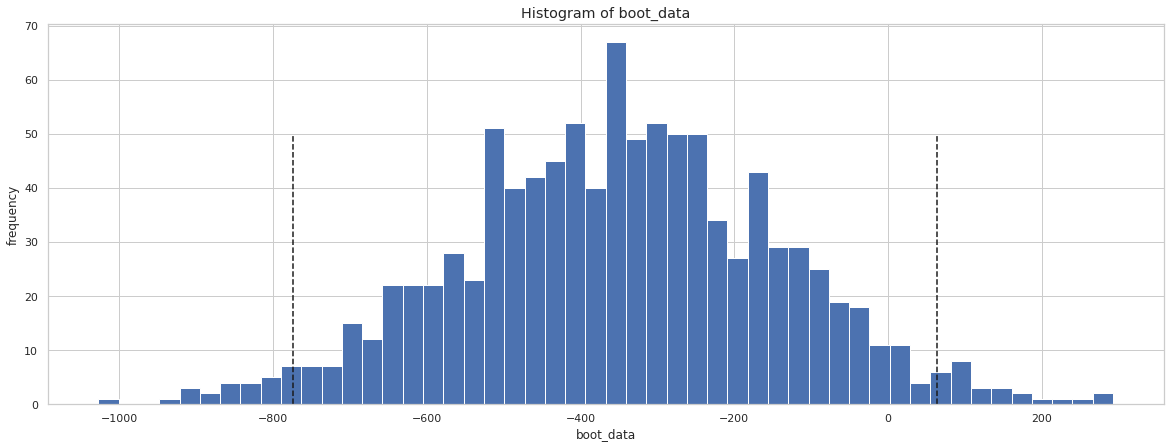

In [45]:
#19. Применяем бутстрап для метрики ARPPU
bootstrap_mean_paying = get_bootstrap(paying_group_a, paying_group_b)

In [46]:
#20. Результат сравнения
bootstrap_mean_paying["p_value"]

0.08993942272163818

In [47]:
#21. Подготовка данных для бутстрапа
group_a = data.query("testgroup == 'a'")['revenue']
group_b = data.query("testgroup == 'b'")['revenue']

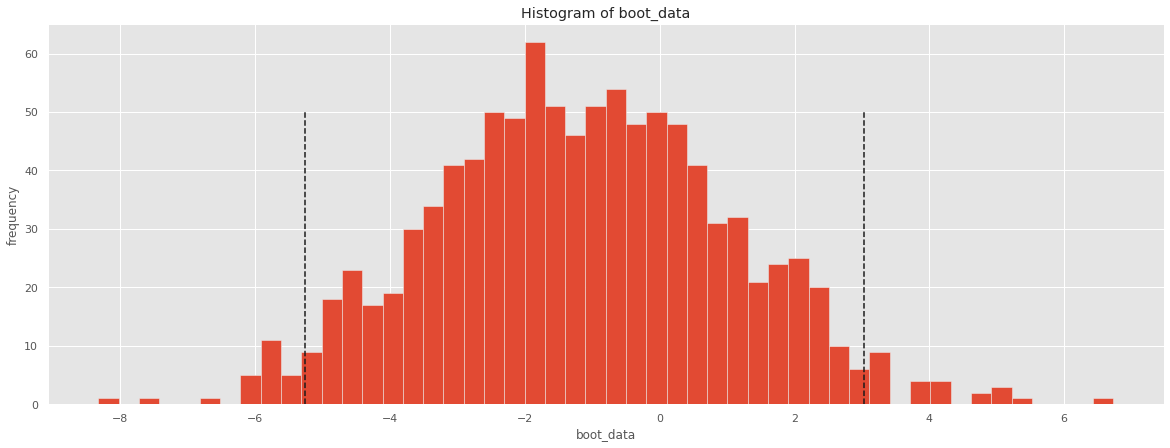

In [48]:
#22. Применяем бутстрап для метрики ARPU
bootstrap_mean = get_bootstrap(group_a, group_b)

In [49]:
#23. Результат сравнения
bootstrap_mean["p_value"]

0.5915351030766451

Выводы.

Было проведено исследование двух групп (a и b), которым предлагались различные акционные варианты. Мы посчитали количество платящих пользователей (=покупателей) в каждой группе, посчитали объем дохода, который был получен из каждый группы. Кроме этого, были рассчитаны метрики ARPPU (=средний чек для наших данных), ARPU, CR. Если метрики ARRPU и ARPU были выше в группе b чем в группе а, то конверсия была почти равной в данных группах.

Однако, как показывает тест Шапиро и как мы видим из полученный гистограммы, распределение данных о полученном доходе отклоняется от нормального. Как мы заметили, были значительные выбросы в группе а.

Далее, необходимо было определить есть ли статистическая зависимость в метриках среди групп. Насколько полученные результаты "оправдывают" различия между группами. 

Для определения статистической значимости был проведен тест Манна-Уитни и был применен метод Бутстрап. 
Как показывают результаты, при сравнении метрики ARPU между группами оба подхода показывают отсутствие значемых различий (p-value > 0.05), и мы не можем отклонить нулевую гипотезу (H0 - различий между средними нет). А при сравнение метрики ARPPU между группами, мы получаем интересную картину: тест Манна-Уитни говорит, что различия есть ( p-value < 0.05), а бутсрап показывает что различия отсутствуют (p-value > 0.05). Это может быть обусловлено тем, что тест Манна-Уитни при сравнение средних значений ранжирует данные, и учитывая, что при расчете ARPPU берутся только покупки, то нули отбрасываются. Кроме того, на результаты бутстрапа мешают выбросы, которые имеются в данных.

Таким образом, учитывая, что конверсия у групп была почти равной и природу данных, сложно сказать какое из предложений лучше всего. Для принятия правильного решения следует провести дополнительный анализ при этом отрезая полученный выбросы в группах.

ЗАДАЧА 3.

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Насколько я понимаю данные события больше всего направлены для игроков, которые уже являются юзерами данной игры. И суть данных мероприятий в том, чтобы повышать активность юзеров данного приложения, а привлечение аудитории может быть второстепенной целю. Для оценки результатов последнего прошедшего события можно было бы применять следующие метрики:

    1. AU (active users) - количество уникальных пользователей, у которых был хотя бы 1 заход во время проведения таких событий.
    2. DAU - количетсов уникальных пользователей, у которых был хотя бы 1 заход в игру в течении дня (если события проводятся несколько дней).
    3. Max_Session_Lenght - максимальная непрерывная продолжительность сессии для уникальных пользователей во время проведения событий.
    4. Retention_rate (7, 30 days) - уровень удержания новых пользователей, которые подключились в игру в момент проведения событий.
    5. Churn_rate (30 days) - количество игроков, которые не были активны в последующие 30 дней после проведения мероприятия.
    
При усложнении механики событий, также можно применять данные метрики. Особенно в таком наборе метрик, лоялность и заинтересованность игроков можно было бы оценить через комбинацию метрик "max_session_length" + "churn_rate", так как данная комбинация хорошо сигнализирует ситуацию, когда при усложненной механике игроки покидают игру и не возвращаются.